# Análisis Exploratorio de Datos (1)

## Posibles Objectivos:

* **Predecir  el retraso de los vuelos**
* Analizar factores relacionados con los vuelos causantes de retraso
* Analizar factores relacionados con vuelos con retraso atribuible a la aerolínea.
* Classificar Aeropuertos
* Classificar Aerolíneas



## Lectura inicial

Definir SparkContext y SQLContext

In [1]:
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SQLContext
sqlContext=SQLContext(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/22 10:58:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/02/22 10:58:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/home/aldos/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Lectura del fichero de trabajo

In [2]:
bd = sqlContext.read.format("com.databricks.spark.csv"
).option("header", "true"
).load("../On_Time_On_Time_Performance_2016_12.csv", inferSchema=True
)

## Pre-proceso inicial

Filtro variables de interés y principales aeropuertos

In [3]:
bd=bd.select('Year','Month','DayofMonth','DayOfWeek','CRSDepTime','UniqueCarrier', 'TailNum', 'ArrDelay','DepDelay','Origin','Dest','Distance','Cancelled', 'Diverted','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay') 

In [4]:
sqlContext.registerDataFrameAsTable(bd, "bd")
bd2 = sqlContext.sql("select * from bd \
            where Origin in ('ATL','ORD','DEN','LAX','DFW','SFO','PHX','LAS') \
            and Dest in ('ATL','ORD','DEN','LAX','DFW','SFO','PHX','LAS')")
sqlContext.registerDataFrameAsTable(bd2, "bd2")

22/02/22 11:04:47 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Exploración de Variables
Los datos (variables) son características observables de los individuos de una población. Éstas variables pueden ser:

* __CUALITATIVAS__: etiquetas (numéricas o no) que representan el grupo o categoría al cual pertenece un individuo. Se puede diferenciar entre nominales y ordinales.

* __CUANTITATIVAS__: valores numéricos para los cuales tiene sentido hacer aritmética. Se puede diferenciar entre valores enteros  (discretos) y valores medidos en cierta escala (continuos).


## Exploración de Variables Cualitativas
* Número de casos disponibles
* Número de categorías
* Frecuencias relativas
* Frecuencias absolutas
* Frec. relativa acumulada
* Frec. absoluta acumulada

In [5]:
bd2.count()

30965

In [6]:
bd2.select("Dest").distinct().count()

8

In [7]:
bd2.groupBy("Dest").count().show()

+----+-----+
|Dest|count|
+----+-----+
| LAS| 3726|
| DEN| 3967|
| PHX| 3302|
| DFW| 3275|
| SFO| 4430|
| ATL| 3094|
| ORD| 3829|
| LAX| 5342|
+----+-----+



In [8]:
sqlContext.sql("select Dest, count(*) as n , round(  100*count(*)/30965  ,2) as p \
                from bd2 \
                group by Dest  ").show()

+----+----+-----+
|Dest|   n|    p|
+----+----+-----+
| LAS|3726|12.03|
| DEN|3967|12.81|
| PHX|3302|10.66|
| DFW|3275|10.58|
| SFO|4430|14.31|
| ATL|3094| 9.99|
| ORD|3829|12.37|
| LAX|5342|17.25|
+----+----+-----+



In [9]:
sqlContext.sql("select t1.Dest , t1.n , 100*t1.n/t2.t as p\
               from (select Dest, count(*) as n from bd2 group by Dest ) as t1 , \
               (select count(*) as t from bd2) as t2").show()

+----+----+------------------+
|Dest|   n|                 p|
+----+----+------------------+
| LAS|3726|12.032940416599386|
| DEN|3967|12.811238495075084|
| PHX|3302|10.663652510899402|
| DFW|3275|10.576457290489262|
| SFO|4430|14.306475052478605|
| ATL|3094| 9.991926368480543|
| ORD|3829|12.365574035201034|
| LAX|5342|17.251735830776685|
+----+----+------------------+



## Exploración de Variables Cuantitativas

* Número de casos disponibles
* Medidas de localización
  * Media: centro de masas
  * Mediana: punto medio (50% de la muestra)
* Medidas de dispersión  
  * Varianza / desviación estándar
  * Cuartiles Q3 y Q1 (25% y 75% de la muestra)
  * Rango Intercuartílico: IQR = Q3 – Q1
  * Rango = max – min
* Valores extremos
  * Máximo y Mínimo;  Top y Bottom
  * Percentiles (1%, 99%)
  * Porcentaje de casos 'por encima/debajo de'.

In [10]:
bd2.describe("ArrDelay").show()

+-------+------------------+
|summary|          ArrDelay|
+-------+------------------+
|  count|             30466|
|   mean|13.300695857677411|
| stddev| 53.50946738163739|
|    min|             -53.0|
|    max|            2028.0|
+-------+------------------+



In [11]:
bd2.select('ArrDelay').groupBy().max().collect()

[Row(max(ArrDelay)=2028.0)]

In [12]:
sqlContext.sql("select min(ArrDelay) as Min, \
                max(ArrDelay) as Max from bd2" ).show()

+-----+------+
|  Min|   Max|
+-----+------+
|-53.0|2028.0|
+-----+------+



In [13]:
bd2.select('ArrDelay').orderBy('ArrDelay',ascending=False).show(10)

+--------+
|ArrDelay|
+--------+
|  2028.0|
|  1505.0|
|  1006.0|
|   996.0|
|   951.0|
|   920.0|
|   920.0|
|   873.0|
|   872.0|
|   868.0|
+--------+
only showing top 10 rows



In [14]:
n=bd2.select('ArrDelay').count()
P95=int(n*0.95)
bd2.select('ArrDelay').sort('ArrDelay').collect()[P95]

Row(ArrDelay=103.0)

## Representación gráfica de Variables Cualitativas


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
g1=sqlContext.sql("select Dest, count(*) as n from bd2 group by Dest")
pdf1=g1.toPandas()
pdf1

,Dest,n
0,LAS,3726
1,DEN,3967
2,PHX,3302
3,DFW,3275
4,SFO,4430
5,ATL,3094
6,ORD,3829
7,LAX,5342


<AxesSubplot:xlabel='Dest'>

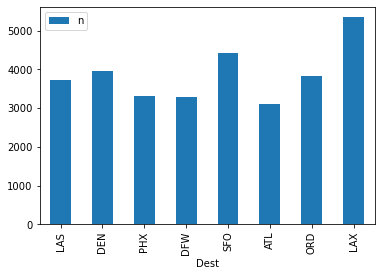

In [17]:
pdf1.plot(kind='bar',x='Dest',y='n')

<AxesSubplot:ylabel='Dest'>

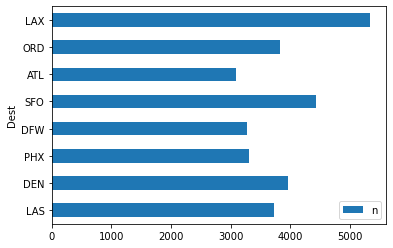

In [18]:
pdf1.plot(kind='barh',x='Dest',y='n')

<AxesSubplot:ylabel='n'>

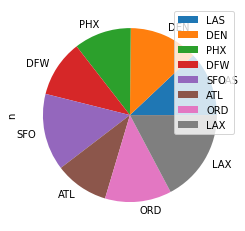

In [19]:
pdf1.plot.pie(y='n',labels=pdf1['Dest'])

## Representación gráfica de Variables Cuantitativas


Sólo se representan los datos de una muestra

In [20]:
#pdf2 = bd2.select('ArrDelay').toPandas()
pdf2 = bd2.sample(False, 0.1, 0).select('ArrDelay').toPandas()

<AxesSubplot:ylabel='Frequency'>

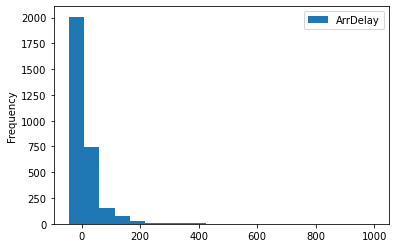

In [21]:
pdf2.plot.hist(bins=20)

<AxesSubplot:>

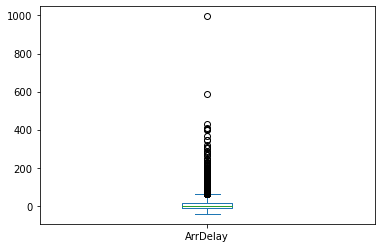

In [22]:
pdf2.plot.box()